# Exercise 1: Sphere Packing
Kanishk Bhatia | 
Matrikelnummer: 03739535

In [1]:
# from phi.flow import *
from phi.torch.flow import *
# from phi.tf.flow import *
import matplotlib.pyplot as plt

math.set_global_precision(64)

## (a) Setup

### Constants

In [97]:
eps=0.000001

### Spheres sampling function

In [100]:
def generate_spheres(n_particles, space_low, space_high):
    radius_1 = 1.0
    radius_2 = 0.7

    samples = numpy.random.uniform(low=space_low, high=space_high, size=([n_particles,2]))
    x = math.tensor(samples, instance('particles'), channel(vector='x,y'))

    # radii = numpy.full(([n_particles,1]), radius_1)
    # radii[int(n_particles/2):] = radius_2
    # samples = np.append(samples, radii, axis=1)
    # x = math.tensor(samples, instance('particles'), channel(vector='x,y,radius'))
    # vis.plot( PointCloud(Sphere(x.vector['x','y'], radius=x.vector['radius']), bounds=Box(x=(space_low, space_high),y=(space_low, space_high))))

    radii = [1]*int(n_particles/2) + [0.7]*int(n_particles/2)
    radii_tensor = math.stack(radii, instance('particles'))
    
    return x, radii_tensor

In [63]:
# x_this
# x = x_this
# vis.plot( PointCloud(Sphere(x, radius=radii_tensor*np.sqrt(2), bounds=Box(x=(space_low, space_high),y=(space_low, space_high)))), lib='matplotlib')

## (b) Energy Function

#### Overlap
For each particle
$ overlap_{self,other} = r_{self} + r_{other} - distance_{self,other} = r_{self+other} - distance_{self,other} $

#### Energy function
$ E = 0 $                   for overlap < 0

$ E = C.overlap^2 $         otherwise (some constant C)

distance ```dx = x - math.rename_dims(x, ’particles’, ’others’)```

In [64]:
def calculate_energy(x, radii_tensor):
    '''
    Calculate energy of each particle vs another particle.
    Return an N by N matrix
    
    Args:
        x: Tensor containing particle positions (instances, vector)
        radii_tensor: tensor containing particle radii (instances)
    
    '''
    r = x - math.rename_dims(x, 'particles', 'i')
    distances = math.vec_length(r, eps=eps) # using an epsilon to avoid zero on diagonals... in order to avoid inf gradients later
#     print('distances computed.')
#     math.print(distances)
    radii_sums = radii_tensor + math.rename_dims(radii_tensor, 'particles', 'i')
    # print('sum of radii:')
    # math.print(radii_sums)
    overlaps = radii_sums - distances
    overlaps = math.where(overlaps>=0, overlaps, 0) # set negative overlaps to zero
#     print('overlaps computed. ')
#     math.print(overlaps)

    C = 1.0 # nach deiner Wahl
    Energy_tensor = C * overlaps * overlaps

    # Set diagonal energy to eps
#     Energy_numpy = Energy_tensor.numpy('particles,i')
#     np.fill_diagonal(Energy_numpy, eps)
#     Energy_tensor = tensor(Energy_numpy, Energy_tensor.shape)
    
#     Energy_tensor = 
    
#     print("Energy Tensor computed.")
#     math.print(Energy_tensor)
    
    # Sum of all particle-particle energies except self-self (sum the lower triangle)
#     total_energy = 0.0
#     for row in range(0, Energy_tensor.particles.size):
#         for col in range(0, row):
#             total_energy += Energy_tensor.particles[row].i[col].numpy()
#     return total_energy
    return Energy_tensor

# Energy_tensor = calculate_energy(x, radii_tensor)
# math.print(Energy_tensor)
# system_energy = calculate_energy(x, radii_tensor)
# print('total system energy = ', system_energy)

## (c) Gradient Descent Optimization

In [65]:
def apply_boundary_condition(x, box_low, box_high):
    x = math.where(x <= box_high, x, box_low + x-box_high)  # TOP and RIGHT boundary
    x = math.where(x >= box_low,  x, box_high+x)            # BOTTOM and LEFT boundary
    x = math.where(x <= box_high, x, box_low + x-box_high)  # once more for sanity
    x = math.where(x >= box_low,  x, box_high+x)            # once more for sanity
    return x
# x = apply_boundary_condition(x, space_low, space_high)
# math.print(x)

In [104]:
def my_gradient_descent(x, radii_tensor, descent_rate, tolerance, max_iter):
#     x_list = []
#     energy_list = []
    for iter_count in range(0, max_iter):
        
        print('iteration: ', iter_count)
        '''
        energy = calculate_energy(x, radii_tensor)
        math.print(math.l2_loss(energy))
        dx, = math.functional_gradient(calculate_energy, get_output=False)(x, radii_tensor)
        update = -0.1 * dx
        x = x + update

        energy = calculate_energy(x, radii_tensor)
        math.print(math.l2_loss(energy))
        '''
        
#         energy = calculate_energy(x, radii_tensor)
#         math.print(math.l2_loss(energy))
        dx, = math.functional_gradient(calculate_energy, get_output=False)(x, radii_tensor)
        
#         print('iteration: ',iter_count)
#         print('x = ' )
#         math.print(x)
#         print('dx = ' )
#         math.print(dx)
        
        update = -0.1 * dx
        residual = math.l2_loss(update)
        if residual.numpy() < tolerance:
            break;

        x = x + update
    
        x = apply_boundary_condition(x, space_low, space_high)
        
#         energy = calculate_energy(x, radii_tensor)
#         math.print(math.l2_loss(energy))

#         x_list.append(x)
        
#         energy = calculate_energy(x, radii_tensor)
#         energy_list.append(math.l2_loss(energy))
    
#     return x, energy_list, iter_count+1
    return x, iter_count+1


### For testing GD

In [75]:
# energy = calculate_energy(x, radii_tensor)
# math.print(math.l2_loss(energy))
# dx, = math.functional_gradient(calculate_energy, get_output=False)(x, radii_tensor)
# update = -0.1 * dx
# x = x + update

# energy = calculate_energy(x, radii_tensor)
# math.print(math.l2_loss(energy))

In [76]:
# vis.plot( PointCloud(Sphere(x, radius=radii_tensor*np.sqrt(2), bounds=Box(x=(space_low, space_high),y=(space_low, space_high)))), lib='matplotlib')

In [77]:
# x = apply_boundary_condition(x, space_low, space_high)
# energy = calculate_energy(x, radii_tensor)
# math.print(math.l2_loss(energy))

In [78]:
# vis.plot( PointCloud(Sphere(x, radius=radii_tensor*np.sqrt(2), bounds=Box(x=(space_low, space_high),y=(space_low, space_high)))), lib='matplotlib')

In [79]:
# energy,dx = math.functional_gradient(calculate_energy)(x, radii_tensor)
# dx = dx[0]
# type(dx)

## Perform Gradient Descent

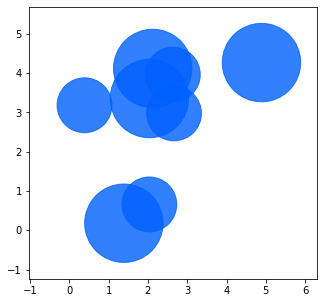

<Figure size 432x288 with 0 Axes>

In [102]:
# Sampling
n_particles = 8
space_low = 0
space_high = 5
x, radii_tensor = generate_spheres(n_particles, space_low, space_high)

vis.plot( PointCloud(Sphere(x, radius=radii_tensor*np.sqrt(2), bounds=Box(x=(space_low, space_high),y=(space_low, space_high)))), lib='matplotlib')

In [107]:
# Perform GD
descent_rate = 0.1
max_iter = 50
tolerance = 0.001
x, iter_count = my_gradient_descent(x, radii_tensor, descent_rate, tolerance, max_iter)
# math.print(x)
print("Number of GD iterations: ", iter_count)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
Number of GD iterations:  4


### Final packing

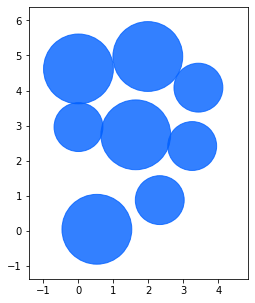

<Figure size 432x288 with 0 Axes>

In [108]:
# x_batches = math.stack(x_list, batch('time'))
# x_final = x_list[-1]
vis.plot( PointCloud(Sphere(x, radius=radii_tensor*np.sqrt(2), bounds=Box(x=(space_low, space_high),y=(space_low, space_high)))), lib='matplotlib')

In [90]:
energy_list
# plt.plot(energy_list)

[39.59731949334845]